In [ ]:
import pandas as pd

df = pd.read_csv("/content/parcelsData.csv", nrows=147)

# Exclude rows where Area column equals "Yaqeen"
df = df[df['Area'] != 'Yaqeen']

# Reset index after filtering (optional but recommended)
df = df.reset_index(drop=True)

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Auto-detect width
pd.set_option('display.max_colwidth', None) # Show full column content


df

,project_name,description,Governorate,Town,land_type,Area,Neighborhood,neighborhood_no,parcel_no,political_classification,slope,view_quality,area_m2,land_use_types,land_use_residential,land_use_commercial,land_use_agricultural,land_use_industrial,electricity,water,Sewage,parcel_frontage (m),road_status1,width_m,road_status2,width_m.1,road_status3,width_m.2,parcel_shape,hospitals_facility,schools_facility,police_facility,municipality_facility,LANDFILL_NEARBY,FACTORIES_NEARBY,NOISY_FACILITIES,ANIMAL_FARMS,ownership_document_type,actual_price_per_m2
0,2,2,Hebron,Bani Naim,PRIVATE,Wadi Al-Joz - Industrial Zone Link,Wadi Al-Joz Basin,37,68,AREA_A,Flat (0-5%),GOOD,1010,RESIDENTIAL,True,False,False,False,YES_1PHASE,YES,YES_PUBLIC,25,PUBLIC_EXISTING_UNPAVED,10.0,PUBLIC_EXISTING_UNPAVED,12.0,FALSE,NaN,RECTANGLE,False,True,False,False,False,False,False,False,TABU,90
1,1,1,Hebron,Bani Naim,PRIVATE,Wadi Al-Joz - Industrial Zone Link,Wadi Al-Joz Basin,37,14,AREA_A,Flat (0-5%),GOOD,1562,COMMERCIAL,False,False,False,False,YES_3PHASE,YES,YES_PRIVATE,38,PUBLIC_EXISTING_UNPAVED,16.0,PUBLIC_EXISTING_UNPAVED,10.0,FALSE,NaN,RECTANGLE,False,True,False,False,False,False,True,False,TABU,140
2,3,3,Hebron,Bani Naim,PRIVATE,Wadi Al-Joz - Industrial Zone Link,Wadi Al-Joz Basin,37,16,AREA_A,Moderate (15-30%),GOOD,608,RESIDENTIAL,True,False,False,False,YES_1PHASE,YES,YES_PRIVATE,21,PRIVATE_PROPOSED_UNPAVED,6.0,FALSE,NaN,FALSE,NaN,RECTANGLE,False,True,False,False,False,False,False,False,TABU,65
3,4,4,Hebron,Bani Naim,PRIVATE,Wadi Al-Joz - Industrial Zone Link,Wadi Al-Joz Basin,37,28,AREA_A,Mild (5-15%),GOOD,1557,COMMERCIAL,True,True,False,False,YES_3PHASE,YES,YES_PRIVATE,36,PUBLIC_EXISTING_PAVED,16.0,FALSE,NaN,FALSE,NaN,IRREGULAR,False,True,False,False,False,False,True,False,TABU,120
4,5,5,Hebron,Bani Naim,PRIVATE,Wadi Al-Joz - Industrial Zone Link,Wadi Al-Joz Basin,37,100,AREA_A,Flat (0-5%),GOOD,571,RESIDENTIAL,True,False,False,False,YES_1PHASE,NO,YES_PRIVATE,19,PUBLIC_EXISTING_UNPAVED,12.0,FALSE,NaN,FALSE,NaN,RECTANGLE,False,True,False,False,False,False,False,False,TABU,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,143,143,Hebron,Bani Naim,PRIVATE,Al-Wa'r,Al-Wa'r Basin,11,65,AREA_A,Flat (0-5%),GOOD,501,NaN,True,True,False,False,YES_1PHASE,YES,YES_PRIVATE,17,PUBLIC_EXISTING_PAVED,12.0,FALSE,NaN,FALSE,NaN,RECTANGLE,False,True,False,False,False,False,False,False,TABU,100
113,144,144,Hebron,Bani Naim,PRIVATE,Al-Wa'r,Al-Wa'r Basin,11,67,AREA_A,Flat (0-5%),GOOD,647,NaN,True,False,False,False,YES_1PHASE,YES,YES_PRIVATE,16,PRIVATE_EXISTING_PAVED,4.0,FALSE,NaN,FALSE,NaN,RECTANGLE,False,True,False,False,False,False,False,False,TABU,75
114,145,145,Hebron,Bani Naim,PRIVATE,Al-Wa'r,Al-Wa'r Basin,11,76,AREA_A,Flat (0-5%),GOOD,1075,NaN,True,True,False,False,YES_1PHASE,YES,YES_PRIVATE,21,PUBLIC_EXISTING_PAVED,12.0,PRIVATE_EXISTING_UNPAVED,4.0,FALSE,NaN,RECTANGLE,False,True,False,False,False,False,False,False,TABU,110
115,146,146,Hebron,Bani Naim,PRIVATE,Al-Wa'r,Al-Wa'r Basin,11,81,AREA_A,Flat (0-5%),GOOD,1022,NaN,True,True,False,False,YES_1PHASE,YES,YES_PRIVATE,32,PUBLIC_EXISTING_PAVED,12.0,FALSE,NaN,FALSE,NaN,RECTANGLE,False,True,False,False,False,False,False,False,TABU,120


In [ ]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
import sklearn
print(sklearn.__version__)



1.8.0


In [ ]:
import numpy as np

# -----------------------------
# Drop unused columns
# -----------------------------
data = df.drop(columns=[
    "project_name",
    "description",
    "parcel_no",
    "neighborhood_no",
    "Governorate",
    "actual_price_per_m2",
    "land_use_types",
    "land_type",
    "Town",
    "ownership_document_type"
])

data = data.replace("", np.nan)

# -----------------------------
# Boolean fields → default False
# -----------------------------
boolean_columns = [
    "land_use_residential",
    "land_use_commercial",
    "land_use_agricultural",
    "land_use_industrial",
    "FACTORIES_NEARBY",
    "NOISY_FACILITIES",
    "ANIMAL_FARMS",
    "hospitals_facility",
    "schools_facility",
    "police_facility",
    "municipality_facility",
]

for col in boolean_columns:
    if col in data.columns:
        data[col] = data[col].fillna(0).astype(int)

# -----------------------------
# Road status cleaning
# -----------------------------
VALID_ROAD_STATUSES = {
    "PUBLIC_EXISTING_UNPAVED",
    "PUBLIC_EXISTING_PAVED",
    "PRIVATE_EXISTING_UNPAVED",
    "PRIVATE_EXISTING_PAVED",
    "PRIVATE_PROPOSED_UNPAVED",
    "PUBLIC_PROPOSED_UNPAVED",
    "FALSE",
}

road_status_columns = ["road_status1", "road_status2", "road_status3"]

for col in road_status_columns:
    if col in data.columns:
        data[col] = (
            data[col]
            .astype(str)
            .str.strip()
            .str.upper()
            .replace("NAN", np.nan)
        )

for col in road_status_columns:
    if col in data.columns:
        invalid_mask = (
            data[col].notna() &
            ~data[col].isin(VALID_ROAD_STATUSES)
        )
        data = data[~invalid_mask]

# -----------------------------
# Road widths handling
# -----------------------------
width_columns = ["width_m", "width_m.1", "width_m.2"]

for i, width_col in enumerate(width_columns, start=1):
    status_col = f"road_status{i}"

    if width_col in data.columns and status_col in data.columns:
        data.loc[
            data[status_col].isna() | (data[status_col] == "FALSE"),
            width_col
        ] = 0

        data[width_col] = data[width_col].fillna(0)

# -----------------------------
# Final safety
# -----------------------------
data = data.reset_index(drop=True)
data

,Area,Neighborhood,political_classification,slope,view_quality,area_m2,land_use_residential,land_use_commercial,land_use_agricultural,land_use_industrial,electricity,water,Sewage,parcel_frontage (m),road_status1,width_m,road_status2,width_m.1,road_status3,width_m.2,parcel_shape,hospitals_facility,schools_facility,police_facility,municipality_facility,LANDFILL_NEARBY,FACTORIES_NEARBY,NOISY_FACILITIES,ANIMAL_FARMS
0,Wadi Al-Joz - Industrial Zone Link,Wadi Al-Joz Basin,AREA_A,Flat (0-5%),GOOD,1010,1,0,0,0,YES_1PHASE,YES,YES_PUBLIC,25,PUBLIC_EXISTING_UNPAVED,10.0,PUBLIC_EXISTING_UNPAVED,12.0,FALSE,0.0,RECTANGLE,0,1,0,0,False,0,0,0
1,Wadi Al-Joz - Industrial Zone Link,Wadi Al-Joz Basin,AREA_A,Flat (0-5%),GOOD,1562,0,0,0,0,YES_3PHASE,YES,YES_PRIVATE,38,PUBLIC_EXISTING_UNPAVED,16.0,PUBLIC_EXISTING_UNPAVED,10.0,FALSE,0.0,RECTANGLE,0,1,0,0,False,0,1,0
2,Wadi Al-Joz - Industrial Zone Link,Wadi Al-Joz Basin,AREA_A,Moderate (15-30%),GOOD,608,1,0,0,0,YES_1PHASE,YES,YES_PRIVATE,21,PRIVATE_PROPOSED_UNPAVED,6.0,FALSE,0.0,FALSE,0.0,RECTANGLE,0,1,0,0,False,0,0,0
3,Wadi Al-Joz - Industrial Zone Link,Wadi Al-Joz Basin,AREA_A,Mild (5-15%),GOOD,1557,1,1,0,0,YES_3PHASE,YES,YES_PRIVATE,36,PUBLIC_EXISTING_PAVED,16.0,FALSE,0.0,FALSE,0.0,IRREGULAR,0,1,0,0,False,0,1,0
4,Wadi Al-Joz - Industrial Zone Link,Wadi Al-Joz Basin,AREA_A,Flat (0-5%),GOOD,571,1,0,0,0,YES_1PHASE,NO,YES_PRIVATE,19,PUBLIC_EXISTING_UNPAVED,12.0,FALSE,0.0,FALSE,0.0,RECTANGLE,0,1,0,0,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Al-Wa'r,Al-Wa'r Basin,AREA_A,Flat (0-5%),GOOD,501,1,1,0,0,YES_1PHASE,YES,YES_PRIVATE,17,PUBLIC_EXISTING_PAVED,12.0,FALSE,0.0,FALSE,0.0,RECTANGLE,0,1,0,0,False,0,0,0
113,Al-Wa'r,Al-Wa'r Basin,AREA_A,Flat (0-5%),GOOD,647,1,0,0,0,YES_1PHASE,YES,YES_PRIVATE,16,PRIVATE_EXISTING_PAVED,4.0,FALSE,0.0,FALSE,0.0,RECTANGLE,0,1,0,0,False,0,0,0
114,Al-Wa'r,Al-Wa'r Basin,AREA_A,Flat (0-5%),GOOD,1075,1,1,0,0,YES_1PHASE,YES,YES_PRIVATE,21,PUBLIC_EXISTING_PAVED,12.0,PRIVATE_EXISTING_UNPAVED,4.0,FALSE,0.0,RECTANGLE,0,1,0,0,False,0,0,0
115,Al-Wa'r,Al-Wa'r Basin,AREA_A,Flat (0-5%),GOOD,1022,1,1,0,0,YES_1PHASE,YES,YES_PRIVATE,32,PUBLIC_EXISTING_PAVED,12.0,FALSE,0.0,FALSE,0.0,RECTANGLE,0,1,0,0,False,0,0,0


In [ ]:
y = df.loc[data.index, "actual_price_per_m2"]
y = y.reset_index(drop=True)
data = data.reset_index(drop=True)
X = data


In [ ]:
assert len(X) == len(y)
assert X.index.equals(y.index)


In [ ]:
data['water'] = data['water'].map({'YES': 1, 'NO': 0})
categorical_cols = [
    "Area",
    "Neighborhood",
    "political_classification",
    "parcel_shape",
    "road_status1",
    "road_status2",
    "road_status3",
    "slope",
    "view_quality",
    "electricity",
    "Sewage",
]

numeric_cols = [
    "area_m2",
    "parcel_frontage (m)",
    "width_m",
    "width_m.1",
    "width_m.2",
]

binary_cols = [
    "land_use_residential",
    "land_use_commercial",
    "land_use_agricultural",
    "land_use_industrial",
    "FACTORIES_NEARBY",
    "NOISY_FACILITIES",
    "ANIMAL_FARMS",
    "hospitals_facility",
    "schools_facility",
    "police_facility",
    "municipality_facility",
    "water",
]


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# ----------------------------
# 1. Feature groups
# ----------------------------
categorical_cols = [
    "Area",
    "Neighborhood",
    "political_classification",
    "parcel_shape",
    "road_status1",
    "road_status2",
    "road_status3",
    "slope",
    "view_quality",
    "electricity",
    "Sewage",
]

numeric_cols = [
    "area_m2",
    "parcel_frontage (m)",
    "width_m",
    "width_m.1",
    "width_m.2",
]

binary_cols = [
    "land_use_residential",
    "land_use_commercial",
    "land_use_agricultural",
    "land_use_industrial",
    "FACTORIES_NEARBY",
    "NOISY_FACILITIES",
    "ANIMAL_FARMS",
    "hospitals_facility",
    "schools_facility",
    "police_facility",
    "municipality_facility",
    "water",
]

# ----------------------------
# 2. ColumnTransformer
# ----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("bin", "passthrough", binary_cols),
    ]
)

# ----------------------------
# 3. Decision Tree model
# ----------------------------
model = DecisionTreeRegressor(
    random_state=42
)

# ----------------------------
# 4. Pipeline
# ----------------------------
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", model)
])

# ----------------------------
# 5. GRID SEARCH for best parameters
# ----------------------------
print("=" * 50)
print("GRID SEARCH - Finding Best Parameters")
print("=" * 50)

param_grid = {
    'regressor__max_depth': [3, 4, 6],
    'regressor__min_samples_leaf': [3, 5, 7, 10, 12, 14, 16],
    'regressor__min_samples_split': [5, 8, 10, 12, 14]
}

grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    return_train_score=True,
    n_jobs=-1  # Use all CPU cores
)

print("\nSearching through parameter combinations...")
grid_search.fit(X, y)

print(f"\n✅ Best parameters found: {grid_search.best_params_}")
print(f"✅ Best CV R²: {grid_search.best_score_:.3f}")

# Get the best model
model_pipeline = grid_search.best_estimator_

# Show top 5 parameter combinations
import pandas as pd
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'mean_train_score']
]
print("\nTop 5 Parameter Combinations:")
for idx, row in top_5.iterrows():
    print(f"  {row['params']}")
    print(f"    CV R²: {row['mean_test_score']:.3f} (±{row['std_test_score']:.3f}), Train R²: {row['mean_train_score']:.3f}\n")

print("=" * 50)


GRID SEARCH - Finding Best Parameters

Searching through parameter combinations...
Fitting 5 folds for each of 105 candidates, totalling 525 fits

✅ Best parameters found: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 5}
✅ Best CV R²: 0.830

Top 5 Parameter Combinations:
  {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 5}
    CV R²: 0.830 (±0.074), Train R²: 0.890

  {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 8}
    CV R²: 0.830 (±0.074), Train R²: 0.890

  {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 10}
    CV R²: 0.830 (±0.074), Train R²: 0.890

  {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 12}
    CV R²: 0.830 (±0.074), Train R²: 0.890

  {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 14}
    CV

In [ ]:
from sklearn.model_selection import cross_validate
import numpy as np

# ----------------------------
# COMPREHENSIVE EVALUATION (using best model from Grid Search)
# ----------------------------
print("=" * 50)
print("FINAL MODEL EVALUATION (5-Fold Cross-Validation)")
print("Using best parameters from Grid Search")
print("=" * 50)

print(f"\nBest Parameters: {grid_search.best_params_}")

cv_results = cross_validate(
    model_pipeline,
    X, y,
    cv=5,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_squared_error'],  # Added MSE
    return_train_score=True
)

# R² scores
train_r2 = cv_results['train_r2'].mean()
test_r2 = cv_results['test_r2'].mean()
test_r2_std = cv_results['test_r2'].std()

print(f"\nR² Score:")
print(f"  Train R²: {train_r2:.3f}")
print(f"  Test R²:  {test_r2:.3f} (±{test_r2_std:.3f})")
print(f"  Gap:      {train_r2 - test_r2:.3f}")

# MAE scores
test_mae = -cv_results['test_neg_mean_absolute_error'].mean()
test_mae_std = cv_results['test_neg_mean_absolute_error'].std()

print(f"\nMean Absolute Error (MAE):")
print(f"  Test MAE: {test_mae:.2f} (±{test_mae_std:.2f})")

# MSE scores
test_mse = -cv_results['test_neg_mean_squared_error'].mean()
test_mse_std = cv_results['test_neg_mean_squared_error'].std()

print(f"\nMean Squared Error (MSE):")
print(f"  Test MSE: {test_mse:.2f} (±{test_mse_std:.2f})")

# RMSE scores
test_rmse = -cv_results['test_neg_root_mean_squared_error'].mean()
test_rmse_std = cv_results['test_neg_root_mean_squared_error'].std()

print(f"\nRoot Mean Squared Error (RMSE):")
print(f"  Test RMSE: {test_rmse:.2f} (±{test_rmse_std:.2f})")

# Individual fold results
print(f"\nIndividual Folds (Detailed):")
for i in range(5):
    fold_train_r2 = cv_results['train_r2'][i]
    fold_test_r2 = cv_results['test_r2'][i]
    fold_mae = -cv_results['test_neg_mean_absolute_error'][i]
    fold_mse = -cv_results['test_neg_mean_squared_error'][i]
    fold_rmse = -cv_results['test_neg_root_mean_squared_error'][i]
    print(f"  Fold {i+1}:")
    print(f"    Train R²={fold_train_r2:.3f}, Test R²={fold_test_r2:.3f}")
    print(f"    MAE={fold_mae:.2f}, MSE={fold_mse:.2f}, RMSE={fold_rmse:.2f}")

print("=" * 50)

FINAL MODEL EVALUATION (5-Fold Cross-Validation)
Using best parameters from Grid Search

Best Parameters: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 5}

R² Score:
  Train R²: 0.890
  Test R²:  0.830 (±0.074)
  Gap:      0.060

Mean Absolute Error (MAE):
  Test MAE: 11.99 (±1.45)

Mean Squared Error (MSE):
  Test MSE: 248.10 (±36.59)

Root Mean Squared Error (RMSE):
  Test RMSE: 15.71 (±1.16)

Individual Folds (Detailed):
  Fold 1:
    Train R²=0.866, Test R²=0.915
    MAE=13.40, MSE=243.49, RMSE=15.60
  Fold 2:
    Train R²=0.897, Test R²=0.745
    MAE=10.02, MSE=194.45, RMSE=13.94
  Fold 3:
    Train R²=0.904, Test R²=0.766
    MAE=13.50, MSE=307.62, RMSE=17.54
  Fold 4:
    Train R²=0.895, Test R²=0.802
    MAE=12.48, MSE=258.67, RMSE=16.08
  Fold 5:
    Train R²=0.888, Test R²=0.921
    MAE=10.54, MSE=236.28, RMSE=15.37


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform 10-fold cross-validation using Mean Absolute Error
scores = cross_val_score(
    model_pipeline,  # your pipeline
    X,               # features
    y,               # target
    cv=5,           # N-fold CV
    scoring="neg_mean_absolute_error"  # sklearn uses negative MAE
)

# Convert negative MAE to positive
mean_mae = -scores.mean()
std_mae = scores.std()

print(f"Mean MAE: {mean_mae:.2f}")
print(f"Standard deviation: {std_mae:.2f}")


Mean MAE: 11.99
Standard deviation: 1.45


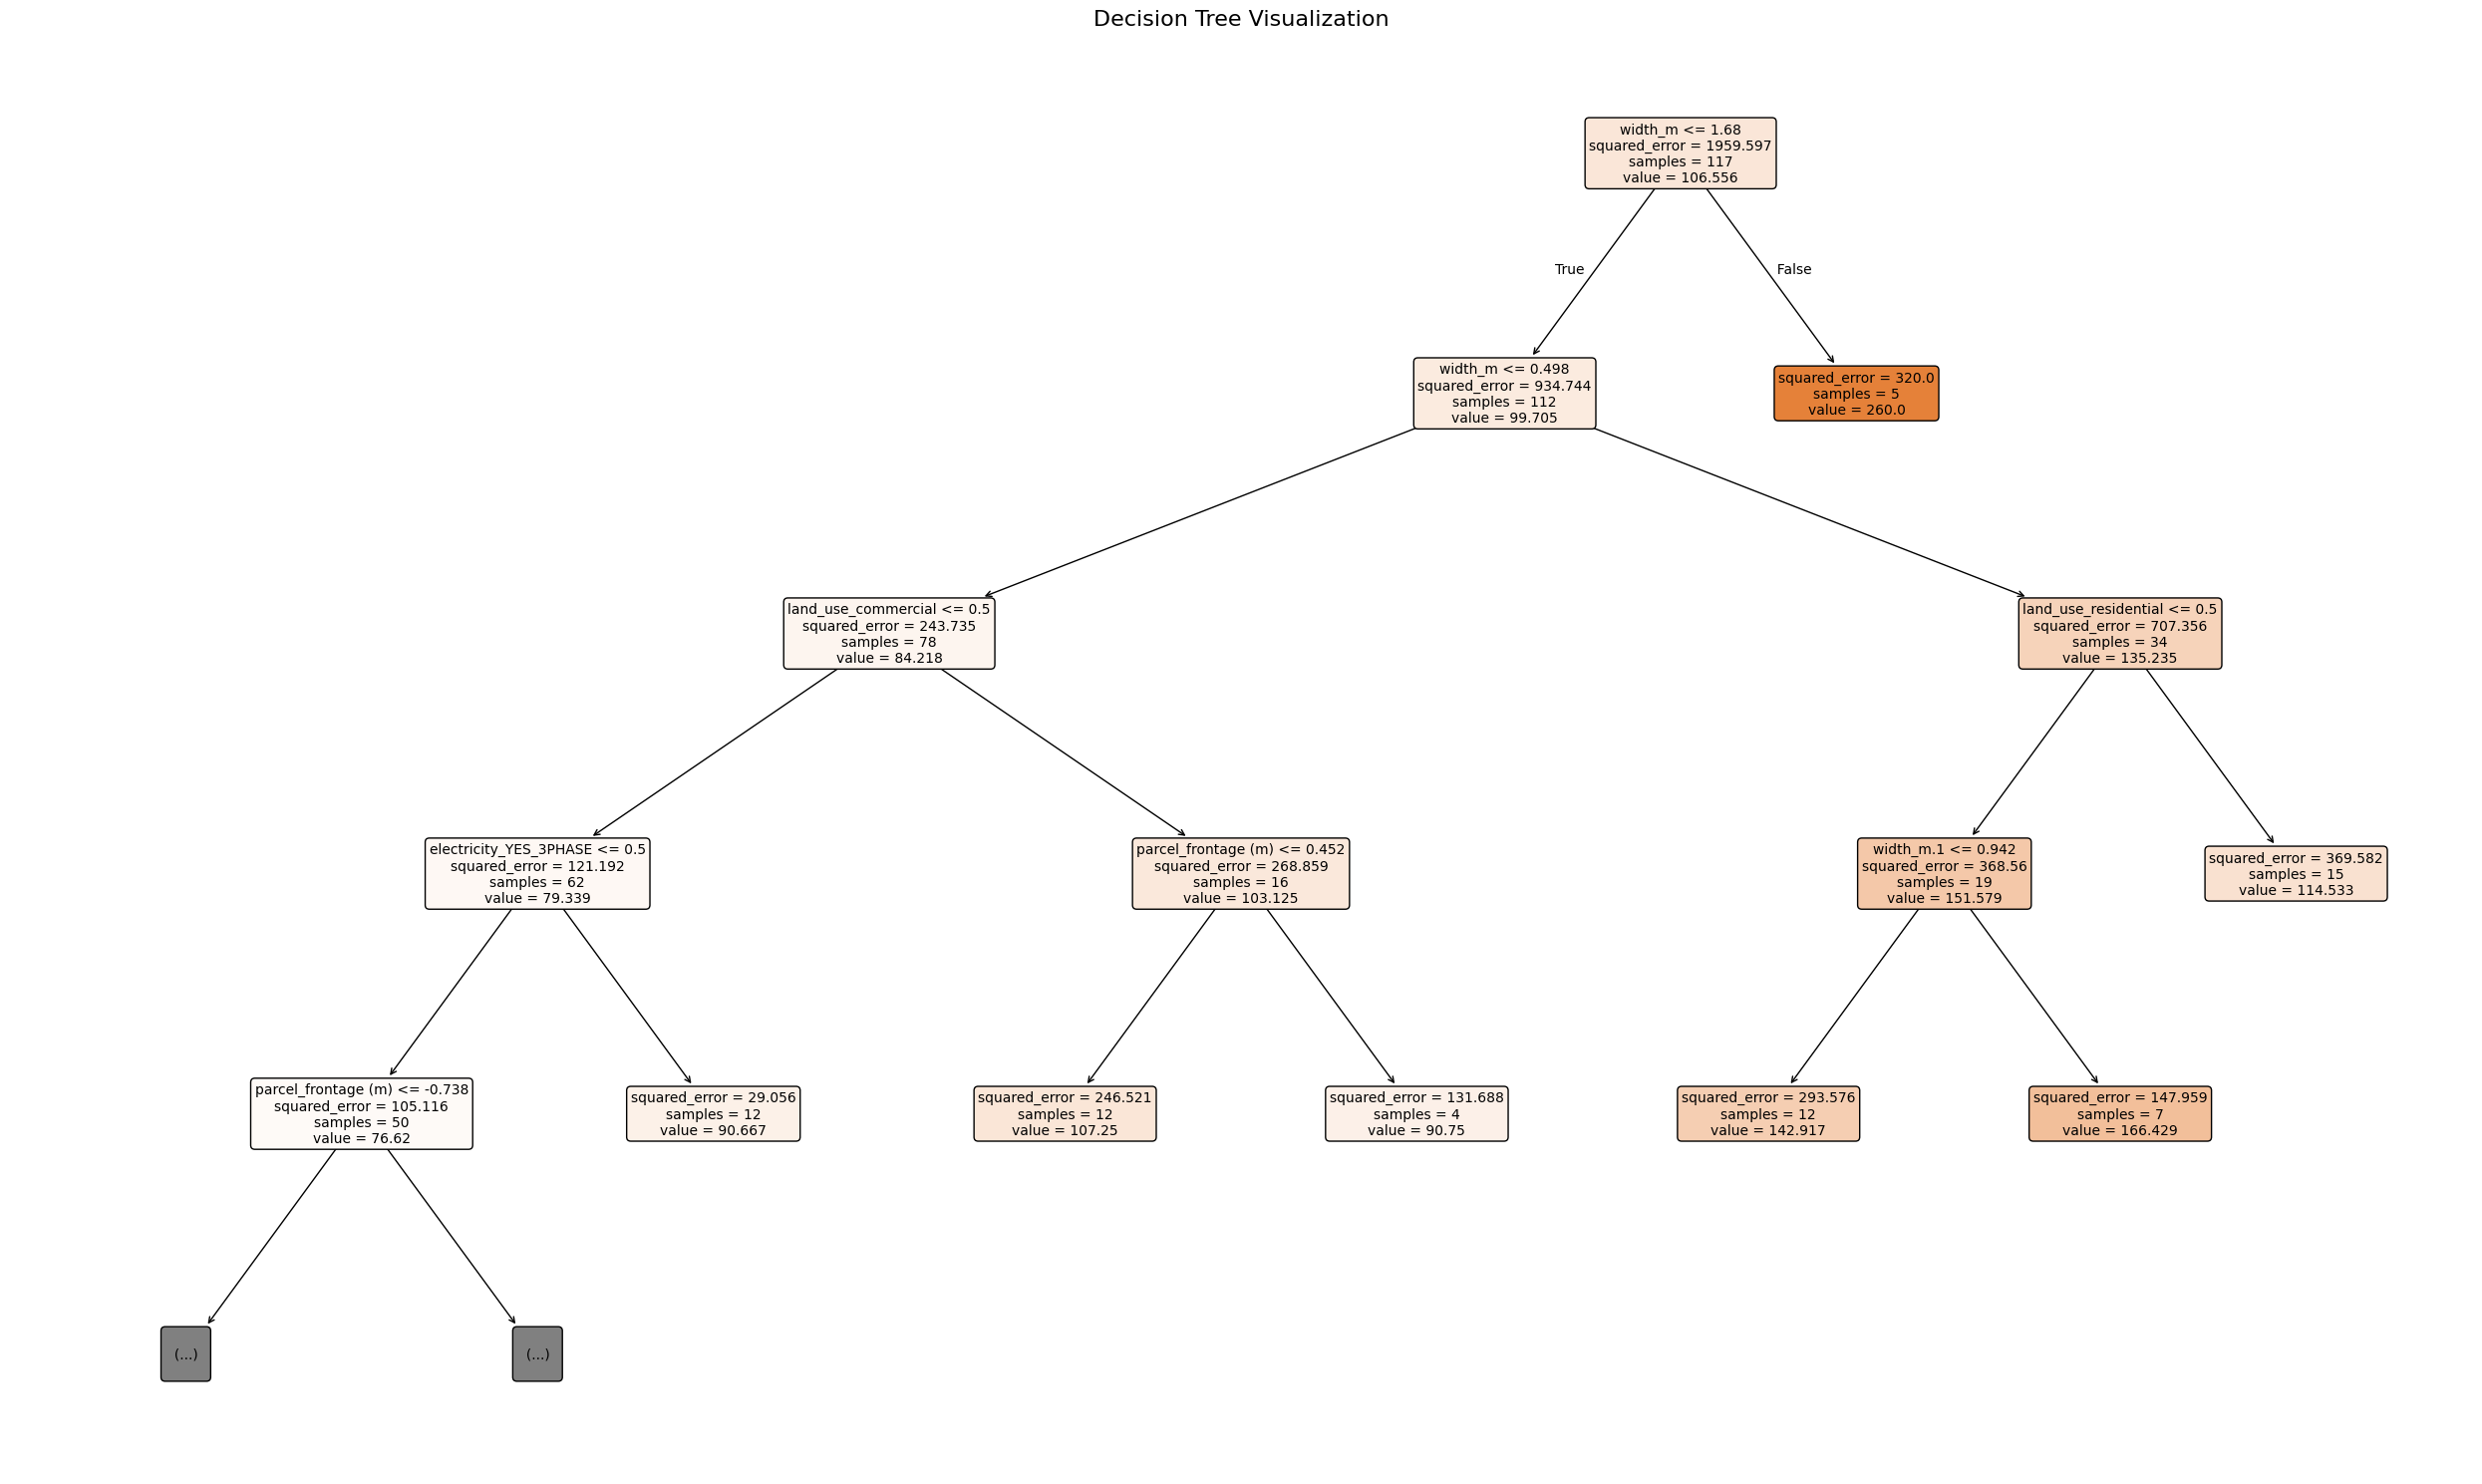

Tree saved as 'decision_tree.png'


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get the decision tree
tree_model = model_pipeline.named_steps['regressor']

# Get feature names (same as above)
feature_names = []
feature_names.extend(numeric_cols)
cat_transformer = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_transformer.get_feature_names_out(categorical_cols)
feature_names.extend(cat_features)
feature_names.extend(binary_cols)

# Create large figure
plt.figure(figsize=(25, 15))

# Plot the tree
plot_tree(
    tree_model,
    feature_names=feature_names,
    filled=True,           # Color nodes by value
    rounded=True,          # Rounded boxes
    fontsize=10,
    max_depth=4            # Limit depth for readability
)

plt.title("Decision Tree Visualization", fontsize=16)
plt.tight_layout()
plt.savefig('decision_tree.png', dpi=300, bbox_inches='tight')  # Save as image
plt.show()

print("Tree saved as 'decision_tree.png'")

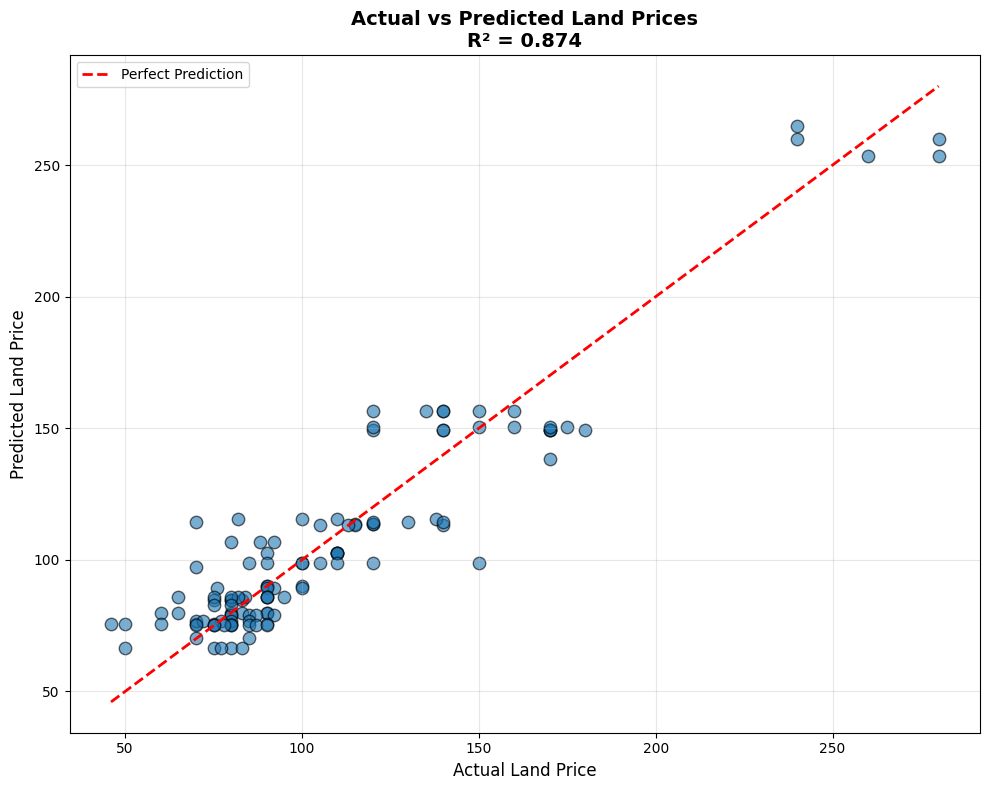

R² Score: 0.874
Plot saved as 'r2_plot.png'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_predict

# Get cross-validated predictions
y_pred = cross_val_predict(model_pipeline, X, y, cv=5)

# Calculate R² for the plot
from sklearn.metrics import r2_score
r2 = r2_score(y, y_pred)

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(y, y_pred, alpha=0.6, edgecolors='k', s=80)

# Perfect prediction line (diagonal)
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Labels and title
plt.xlabel('Actual Land Price', fontsize=12)
plt.ylabel('Predicted Land Price', fontsize=12)
plt.title(f'Actual vs Predicted Land Prices\nR² = {r2:.3f}', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig('r2_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"R² Score: {r2:.3f}")
print(f"Plot saved as 'r2_plot.png'")

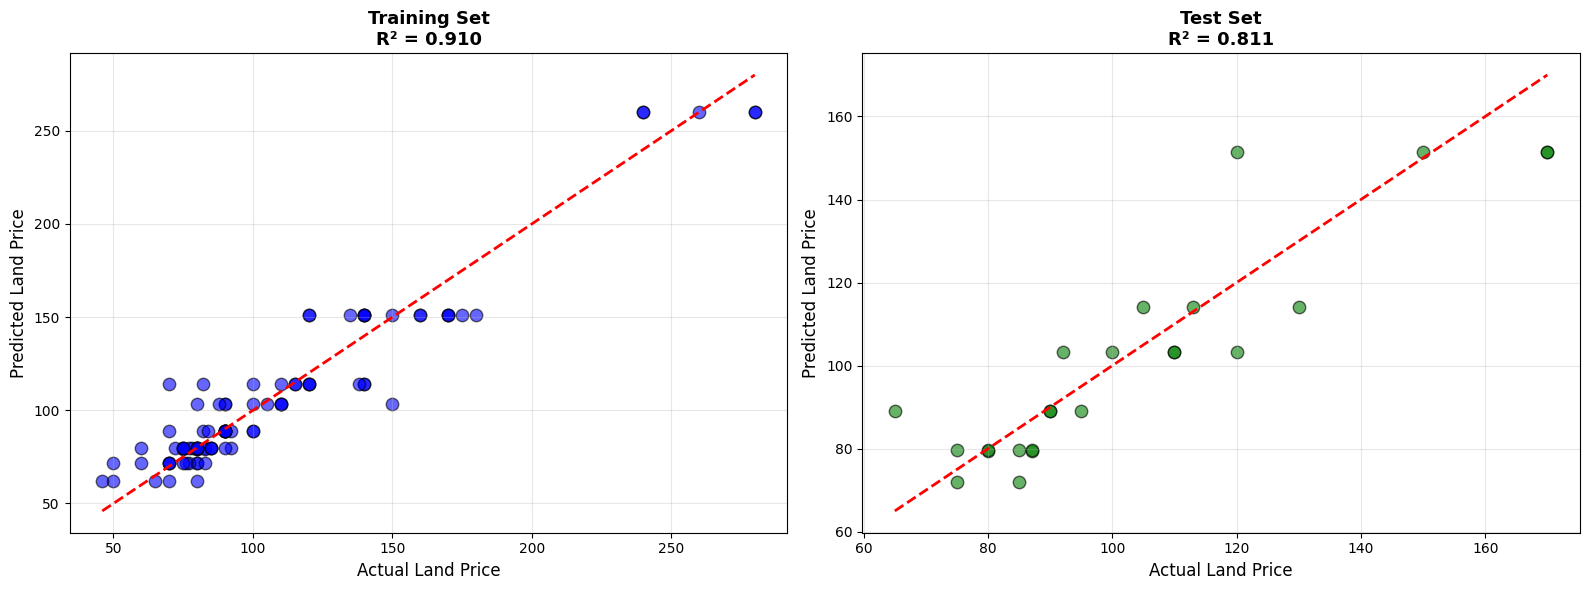

Training R²: 0.910
Test R²: 0.811
Gap: 0.099


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model_pipeline.fit(X_train, y_train)

# Get predictions
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Calculate R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set plot
ax1 = axes[0]
ax1.scatter(y_train, y_train_pred, alpha=0.6, edgecolors='k', s=80, color='blue')
min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
ax1.set_xlabel('Actual Land Price', fontsize=12)
ax1.set_ylabel('Predicted Land Price', fontsize=12)
ax1.set_title(f'Training Set\nR² = {train_r2:.3f}', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Test set plot
ax2 = axes[1]
ax2.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', s=80, color='green')
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
ax2.set_xlabel('Actual Land Price', fontsize=12)
ax2.set_ylabel('Predicted Land Price', fontsize=12)
ax2.set_title(f'Test Set\nR² = {test_r2:.3f}', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('r2_train_test_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Gap: {train_r2 - test_r2:.3f}")

In [ ]:
import joblib

# ----------------------------
# FINAL MODEL TRAINING (on all data)
# ----------------------------
print("\nTraining final model on all 130 samples...")
print(f"Using parameters: {model_pipeline.named_steps['regressor'].get_params()}")

model_pipeline.fit(X, y)

# Save the trained model
joblib.dump(model_pipeline, "land_price_model.pkl")
print("\n✅ Model saved as 'land_price_model.pkl'")

# Show final training performance
final_r2 = model_pipeline.score(X, y)
print(f"✅ Final model R² on full dataset: {final_r2:.3f}")


Training final model on all 130 samples...
Using parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}

✅ Model saved as 'land_price_model.pkl'
✅ Final model R² on full dataset: 0.887
